<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# --- One-shot fix & verify for lapd_eda in Colab ---

import os, sys, importlib, inspect
from textwrap import dedent

# 1) Make sure /content is first so the local file is chosen
if "/content" not in sys.path[:1]:
    sys.path.insert(0, "/content")

EDA_PATH = "/content/lapd_eda.py"
assert os.path.exists(EDA_PATH), f"lapd_eda.py not found at {EDA_PATH}. Upload it there."

# 2) Peek at current file contents and show last lines
print("Using EDA_PATH:", EDA_PATH)
print("File size (bytes):", os.path.getsize(EDA_PATH))
print("Last 40 lines of lapd_eda.py:")
with open(EDA_PATH, "r", encoding="utf-8") as f:
    lines = f.readlines()
print("".join(lines[-40:]))

# 3) If helpers missing, append them
helpers_block = dedent("""
# --------------------------- Cleaning & Task Sampling ---------------------------
from sklearn.model_selection import train_test_split

def clean_then_dropna_all(df):
    \"\"\"
    STRICT NaN policy:
    Drops any row with ANY NaN across the dataframe.
    Assumes prior outlier handling already applied.
    Prints rows removed and returns the cleaned copy.
    \"\"\"
    before = len(df)
    df_clean = df.dropna(axis=0, how="any").copy()
    after = len(df_clean)
    print(f"[CLEAN] Dropped rows with ANY NaN: {before - after:,} removed; {after:,} remain.")
    return df_clean

def stratified_sample_for_task(df, target_col, n=1000, random_state=42):
    \"\"\"
    Stratified sample for classification tasks.
    - Requires a CLEAN dataframe (no NaNs).
    - Drops rows where target is NaN (should be none after clean).
    - Preserves class ratios as much as possible.
    Returns a dataframe of size ~n (exact n if possible).
    \"\"\"
    if target_col not in df.columns:
        raise ValueError(f"target_col '{target_col}' not in dataframe.")
    d = df.dropna(subset=[target_col]).copy()
    m = len(d)
    if m <= n:
        print(f"[SAMPLE] Data has {m:,} rows <= requested {n:,}; returning all rows without sampling.")
        return d

    test_size = n / float(m)
    if not (0.0 < test_size < 1.0):
        test_size = min(0.5, max(0.01, test_size))

    from sklearn.model_selection import train_test_split
    _, d_sample = train_test_split(
        d, test_size=test_size, stratify=d[target_col], random_state=random_state
    )
    # Adjust to exactly n if needed
    if len(d_sample) > n:
        d_sample = d_sample.sample(n=n, random_state=random_state)
    elif len(d_sample) < n:
        need = n - len(d_sample)
        rest = d.drop(d_sample.index)
        add = rest.groupby(target_col, group_keys=False).apply(
            lambda g: g.sample(n=min(len(g), max(0, int(round(need * len(g) / max(1, len(rest)))))), random_state=random_state)
        )
        import pandas as pd
        d_sample = pd.concat([d_sample, add]).head(n)

    print(f"[SAMPLE] Stratified sample for '{target_col}': {len(d_sample):,} rows.")
    return d_sample
""").strip() + "\n"

src = "".join(lines)
if ("def clean_then_dropna_all(" not in src) or ("def stratified_sample_for_task(" not in src):
    with open(EDA_PATH, "a", encoding="utf-8") as f:
        f.write("\n" + helpers_block)
    print("✅ Added helpers to lapd_eda.py")
else:
    print("ℹ️ Helpers already present; not modifying lapd_eda.py")

# 4) Hard reload the module so Python stops using the cached old version
importlib.invalidate_caches()
if "lapd_eda" in sys.modules:
    del sys.modules["lapd_eda"]

import lapd_eda
print("Imported lapd_eda from:", inspect.getfile(lapd_eda))

# 5) Verify attributes exist
missing = [name for name in ("clean_then_dropna_all", "stratified_sample_for_task") if not hasattr(lapd_eda, name)]
if missing:
    raise ImportError(f"Missing in lapd_eda after reload: {missing}")
print("✅ Verified: clean_then_dropna_all & stratified_sample_for_task are available.")


Using EDA_PATH: /content/lapd_eda.py
File size (bytes): 21960
Last 40 lines of lapd_eda.py:
        r = i // grid_w; c = i %  grid_w
        ax.add_patch(plt.Rectangle((c, grid_h-1-r), 1, 1))
        ax.text(c+0.5, grid_h-1-r+0.5, lab[:2] if lab else "", ha="center", va="center", fontsize=9)
    ax.set_xlim(0, grid_w); ax.set_ylim(0, grid_h)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title(title)
    sns.despine(left=True, bottom=True); plt.tight_layout(); return fig

def plot_dumbbell(df, left, right, cat, title="Before vs After (Dumbbell)"):
    _theme()
    d = df.sort_values(by=right, ascending=False)
    y = np.arange(len(d))
    plt.figure(figsize=(10, 0.35*len(d)+2))
    plt.hlines(y, d[left], d[right], linewidth=2)
    plt.plot(d[left], y, 'o', label=left)
    plt.plot(d[right], y, 'o', label=right)
    plt.yticks(y, d[cat]); plt.legend(); plt.title(title); plt.xlabel("Value"); plt.tight_layout()
    return plt.gcf()

def plot_small_multiples_hour_day(df, group_col="crime

Step 1/9: reading CSV…
Loaded shape: (1000, 15) (QUICK_MODE=True)
Step 2/9: normalizing columns…
Step 3/9: inferring datetimes & adding US calendar features…
Step 4/9: text normalization & geo cleanup…
=== Geo issues log ===
                  issue  count
0      zero_zero_coords      1
1       outside_LA_bbox      1
2  duplicate_DR_NO_rows      0
Step 5/9: H3 features…
Skipping H3 features: 'h3' library not installed or lat/lon not available.
Step 6/9: dedupe, downcast, clip…
Step 7/9: strict NaN drop…
[CLEAN] Dropped rows with ANY NaN: 806 removed; 194 remain.
Step 8/9: EDA plots…
=== Data summary (top 20) ===
                         dtype  n_unique  n_missing  pct_missing
dr_no                  float64       194          0          0.0
date_reported           object       160          0          0.0
date_occured            object       101          0          0.0
time_occured             int16        51          0          0.0
area                    object        21          0     

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwltkhb0k/1zbjbzs7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwltkhb0k/1vk_uppe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67395', 'data', 'file=/tmp/tmpwltkhb0k/1zbjbzs7.json', 'init=/tmp/tmpwltkhb0k/1vk_uppe.json', 'output', 'file=/tmp/tmpwltkhb0k/prophet_modela8tz3la9/prophet_model-20250816194959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


\nValidation ranking (lower MAPE is better):
     model   val_MAPE
0     LSTM  28.579208
2  prophet  31.638096
1  sarimax  33.459778
[SAMPLE] Data has 194 rows <= requested 1,000; returning all rows without sampling.
Example classification sample created with shape: (194, 27)
\nDone. EDA in lapd_eda.py; ML in lapd_enhancements.py; US calendar retained. QUICK_MODE=True.


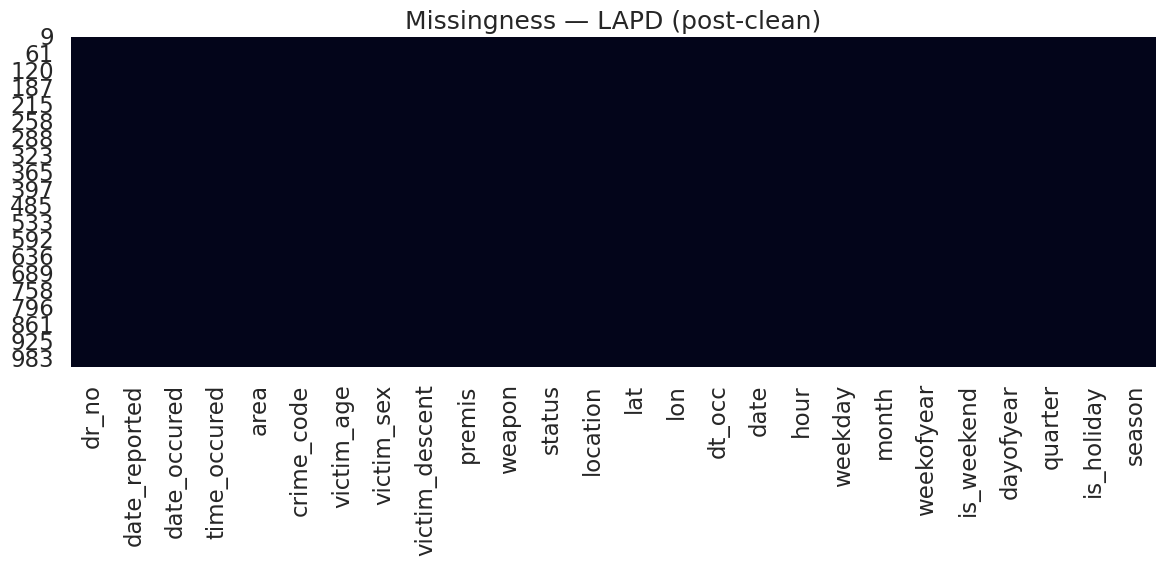

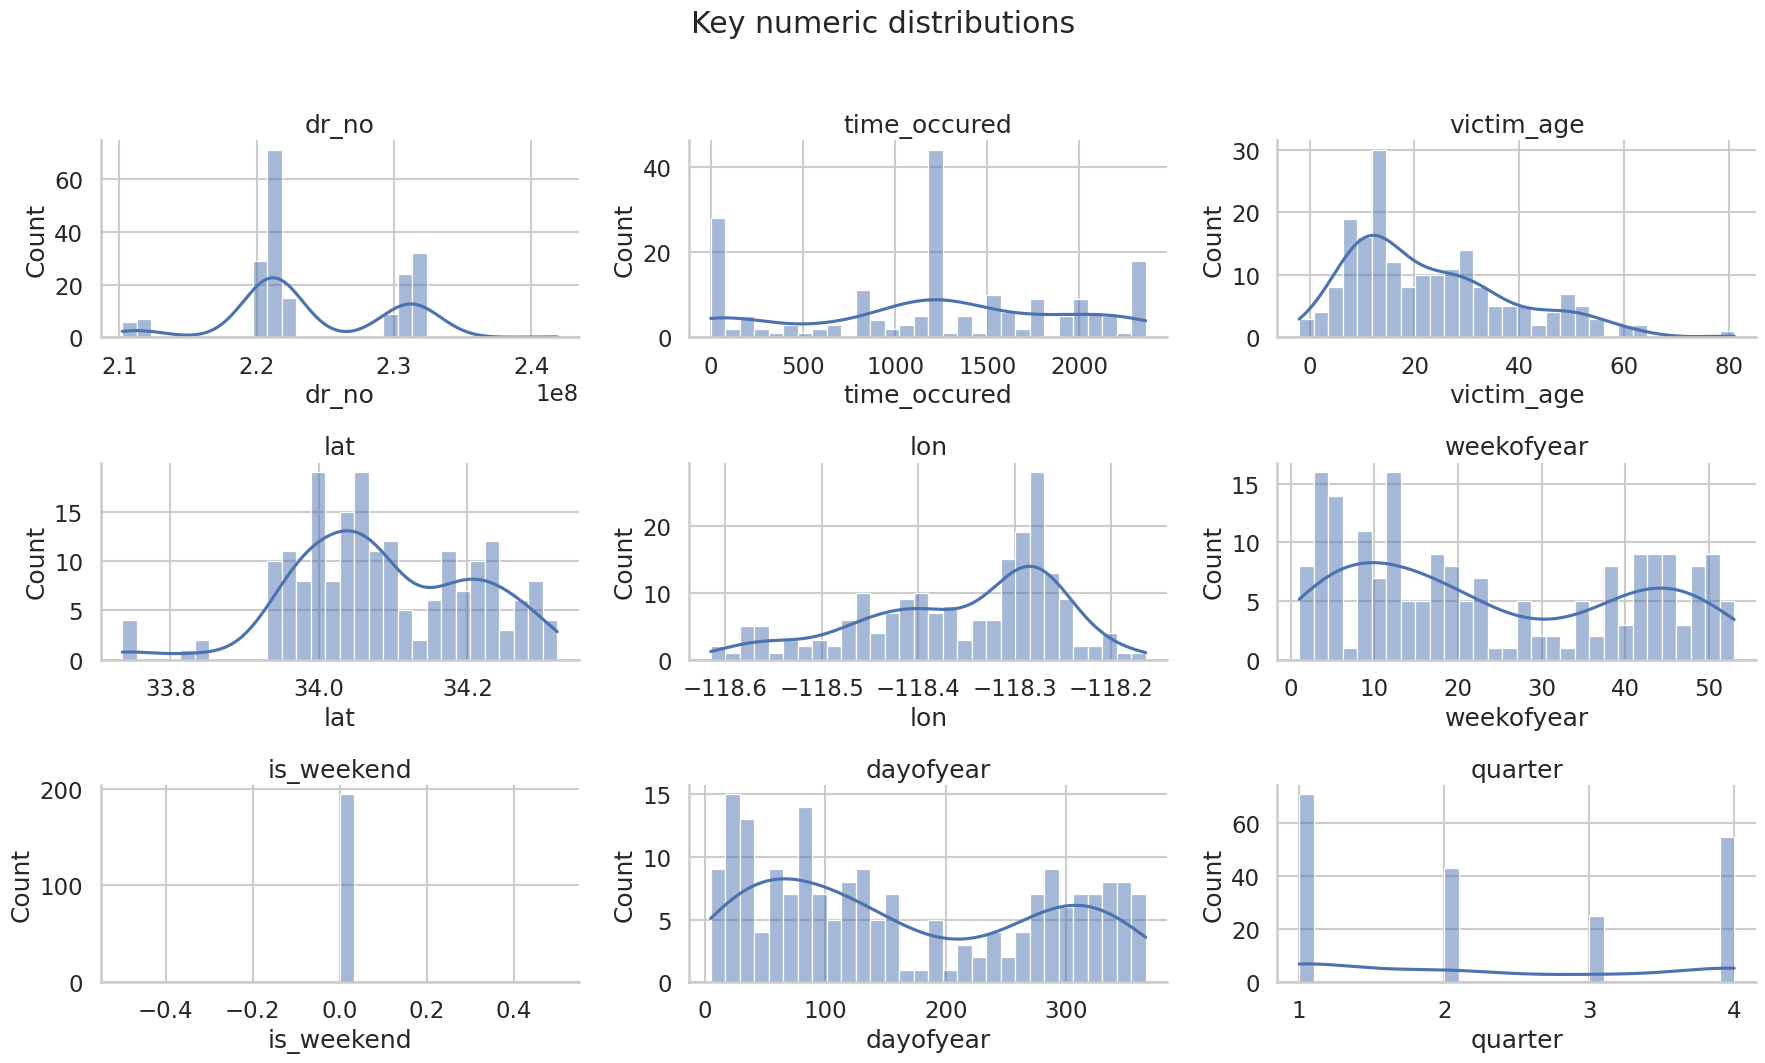

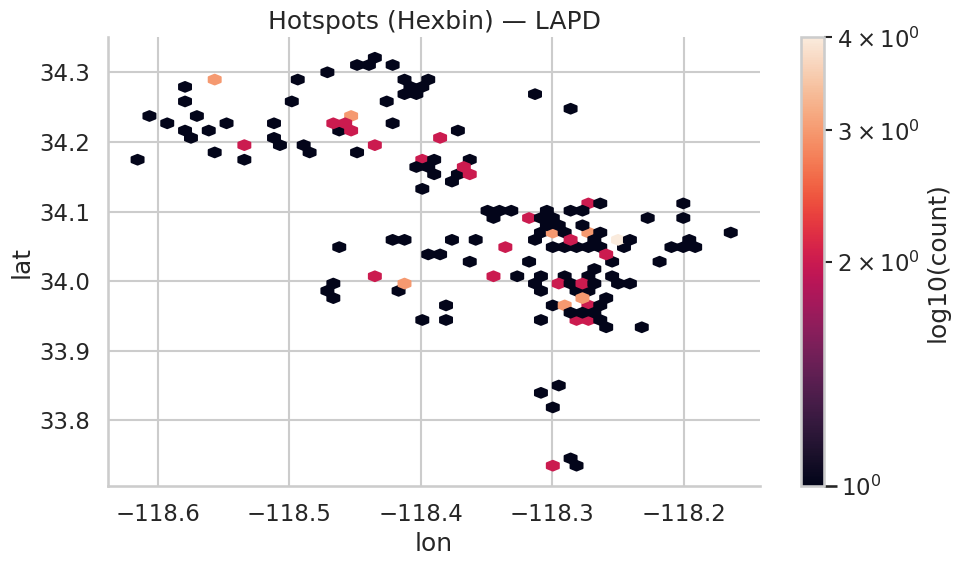

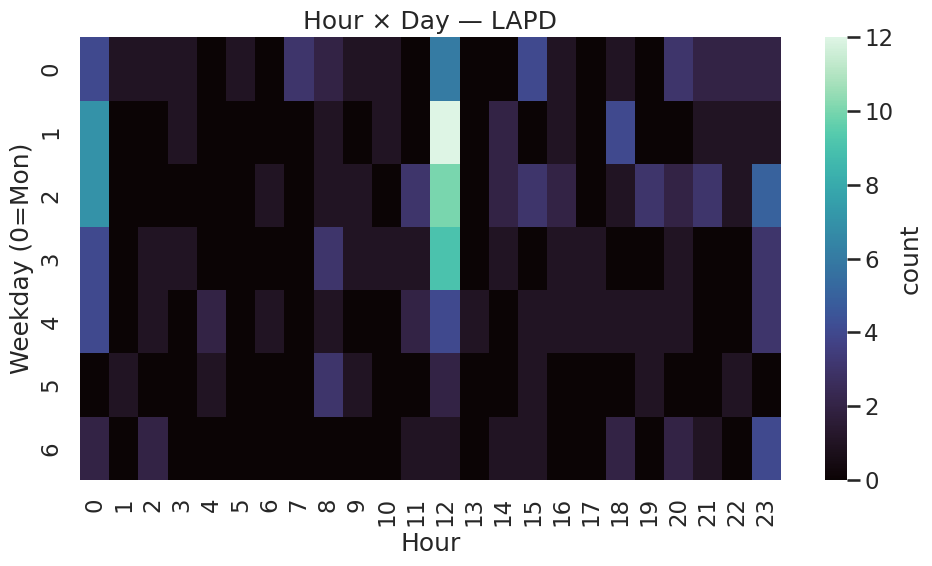

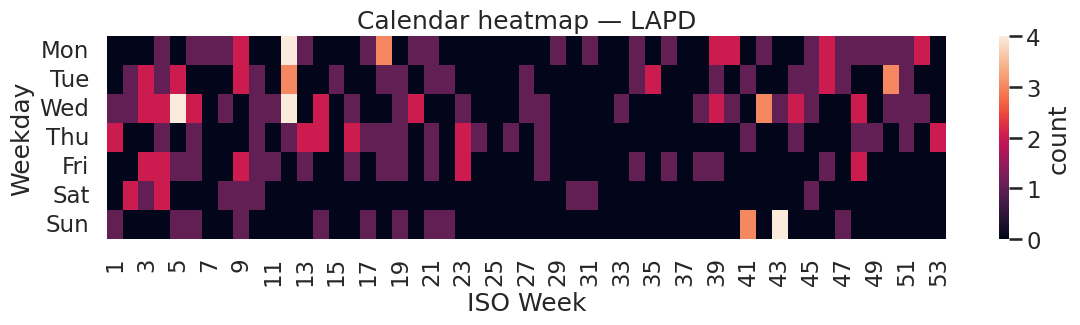

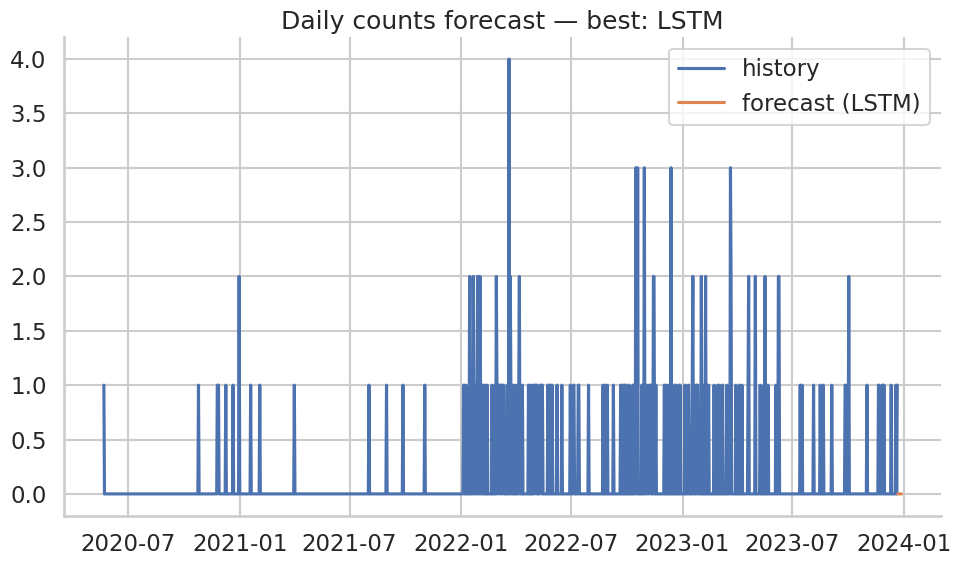

In [17]:

# lapd_true_crime.py
# -------------------------------------------------------------
# Driver that uses: lapd_eda (preproc + EDA) and lapd_enhancements (ML).
# QUICK_MODE keeps all steps but runs them on a small sample,
# while enforcing: (1) outlier handling -> (2) drop ANY NaN -> (3) per-task sampling.
# -------------------------------------------------------------

import os, sys, warnings
warnings.filterwarnings("ignore")

# ---------------- Quick mode switches ----------------
QUICK_MODE = True       # Set False for full dataset
QUICK_NROWS = 1_000     # rows to read when QUICK_MODE=True
UNSUP_MAX_SAMPLES = 5_000  # cap for unsupervised search
FORECAST_LOOKBACK = 60
FORECAST_HORIZON = 7
FORECAST_EVAL_DAYS = 28

# Colab detection & deps (optional)
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install shap lime river pmdarima statsmodels prophet tensorflow umap-learn hdbscan holidays h3 seaborn

sys.path.insert(0, os.getcwd())

from lapd_eda import (
    normalize_columns, infer_datetime_columns, add_time_features,
    validate_and_clean_coords, add_h3_index, build_h3_cell_daily, h3_neighbor_stats, attach_cell_features,
    collapse_rare_categories, text_clean, deduplicate, downcast_numeric, iqr_outlier_clip,
    eda_missingness, eda_summary_table, eda_numeric_histograms, eda_top_categories, eda_corr_mixed,
    plot_hexbin_map, plot_hour_day_heatmap, plot_calendar_heatmap, plot_ridgeline,
    plot_waffle, plot_dumbbell, plot_small_multiples_hour_day, plot_beeswarm,
    clean_then_dropna_all, stratified_sample_for_task   # <-- NEW
)

from lapd_enhancements import (
    run_unsupervised_search, prepare_daily_series, forecast_all_models,
    compute_shap_importance, explain_lime_tabular, ADWINDriftMonitor,
    stream_predict_from_directory, rolling_rate
)

import numpy as np
import pandas as pd

# ---------------- Load data ----------------
CSV_PATH = "/content/Crime_Data_from_2020_to_Present.csv.zip" if IN_COLAB else "Crime_Data_from_2020_to_Present.csv.zip"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Data not found at {CSV_PATH}. Upload it or set the right path.")
print("Step 1/9: reading CSV…")
read_kwargs = dict(low_memory=False)
if QUICK_MODE:
    read_kwargs["nrows"] = QUICK_NROWS
df = pd.read_csv(CSV_PATH, **read_kwargs)
print(f"Loaded shape: {df.shape} (QUICK_MODE={QUICK_MODE})")

# ---------------- Preprocessing ----------------
print("Step 2/9: normalizing columns…")
df = normalize_columns(df)

# Standardize coordinate column names ONCE (before any geo steps)
if "LAT" in df and "lat" not in df:
    df = df.rename(columns={"LAT": "lat"})
if "LON" in df and "lon" not in df:
    df = df.rename(columns={"LON": "lon"})

print("Step 3/9: inferring datetimes & adding US calendar features…")
df, dt_col = infer_datetime_columns(df)
if dt_col is None:
    raise RuntimeError("Could not infer a datetime column; please specify one or precreate 'dt_occ'.")
df = add_time_features(df, dt_col=dt_col, use_us_holidays=True)

print("Step 4/9: text normalization & geo cleanup…")
text_cols = [c for c in ["crm_cd_desc","premis_desc","weapon_desc","status_desc","crime_desc","premise_desc"] if c in df]
df = text_clean(df, text_cols)

# coords cleanup & log issues (LA bbox)
df, issues_log = validate_and_clean_coords(df, lat_col="lat" if "lat" in df else None,
                                           lon_col="lon" if "lon" in df else None)
print("=== Geo issues log ===")
print(issues_log)

# ---------------- H3 pipeline (guarded) ----------------
print("Step 5/9: H3 features…")
try:
    from h3 import h3 as _h3
    HAS_H3 = True
except Exception:
    HAS_H3 = False

if HAS_H3 and {"lat", "lon"}.issubset(df.columns):
    df = add_h3_index(df, lat_col="lat", lon_col="lon", h3_res=8)
    if "h3" in df.columns and df["h3"].notna().any():
        print("H3 column present — building cell/day panel...")
        cell_daily = build_h3_cell_daily(df, date_col="date", h3_col="h3", roll_windows=(7, 28))
        try:
            cell_daily = h3_neighbor_stats(cell_daily, k=1)
            df = attach_cell_features(df, cell_daily, date_col="date", h3_col="h3")
        except Exception as e:
            print("Neighbor stats skipped:", e)
    else:
        print("H3 column missing or all-NaN after cleaning — skipping H3 features.")
else:
    print("Skipping H3 features: 'h3' library not installed or lat/lon not available.")

# Rare collapse & final cleanup
print("Step 6/9: dedupe, downcast, clip…")
if "crm_cd_desc" in df:
    df = collapse_rare_categories(df, "crm_cd_desc", top_n=20)
df = deduplicate(df)
df = downcast_numeric(df)
num_cols_for_clip = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ["hour","weekday","month"]]
df = iqr_outlier_clip(df, num_cols=num_cols_for_clip)

# --------- STRICT NaN drop BEFORE any sampling ---------
print("Step 7/9: strict NaN drop…")
df_clean = clean_then_dropna_all(df)

# ---------------- EDA ----------------
print("Step 8/9: EDA plots…")
summary = eda_summary_table(df_clean)
print("=== Data summary (top 20) ===")
print(summary.head(20))

eda_missingness(df_clean, title="Missingness — LAPD (post-clean)")
num_cols = [c for c in df_clean.select_dtypes(include=[np.number]).columns if c not in ["hour","weekday","month"]][:9]
if num_cols:
    eda_numeric_histograms(df_clean, cols=num_cols, title="Key numeric distributions")
if "crm_cd_desc" in df_clean:
    eda_top_categories(df_clean, "crm_cd_desc", 15, title="Top crime categories")
if {"lat","lon"}.issubset(df_clean.columns):
    plot_hexbin_map(df_clean, x="lon", y="lat", title="Hotspots (Hexbin) — LAPD")
plot_hour_day_heatmap(df_clean, hour_col="hour", weekday_col="weekday", title="Hour × Day — LAPD")
plot_calendar_heatmap(df_clean, date_col="date", title="Calendar heatmap — LAPD")

# ---------------- Unsupervised search (sample AFTER cleaning) ----------------
print("Step 9/9: Unsupervised search & forecasting…")
feat = df_clean[["hour","weekday"]].copy()
feat["is_weekend"] = (feat["weekday"]>=5).astype(int)

# For speed, take a random sample for unsupervised, AFTER cleaning
if len(feat) > UNSUP_MAX_SAMPLES:
    feat_sample = feat.sample(n=UNSUP_MAX_SAMPLES, random_state=42)
else:
    feat_sample = feat.copy()

results, best_tuple, artifacts = run_unsupervised_search(feat_sample, max_samples=UNSUP_MAX_SAMPLES, random_state=42)
print("\\nTop unsupervised configs:")
print(results.head())

# ---------------- Forecasting on CLEAN data ----------------
daily_series = prepare_daily_series(df_clean, date_col="date")
rank, best_name, best_forecast = forecast_all_models(
    daily_series, horizon=FORECAST_HORIZON, lookback=FORECAST_LOOKBACK, eval_days=FORECAST_EVAL_DAYS, verbose=True
)
print("\\nValidation ranking (lower MAPE is better):")
print(rank)

# ---------------- Example: per-task stratified sampling ----------------
# (Replace with your actual target feature when needed)
if "hour" in df_clean.columns:
    d_task = df_clean.copy()
    d_task["is_night"] = (d_task["hour"].between(22, 23) | d_task["hour"].between(0, 5)).astype(int)
    task_sample = stratified_sample_for_task(d_task, target_col="is_night", n=1000, random_state=42)
    # y = task_sample["is_night"]; X = task_sample.drop(columns=["is_night"])
    print(f"Example classification sample created with shape: {task_sample.shape}")

print(f"\\nDone. EDA in lapd_eda.py; ML in lapd_enhancements.py; US calendar retained. QUICK_MODE={QUICK_MODE}.")
